<a href="https://colab.research.google.com/github/ianoughsaid/Web-Scraping-Practice/blob/main/WebScraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is practice for webscraping. I will be finding what stocks are on the DOW 30 then finding the time series for these stocks. Lastly, I will be comparing these stocks to find what influences the movement of the DOW 30



# Retrieving Financial Data

In [ ]:
from urllib.request import urlopen
url = "https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI"

page = urlopen(url)

In [188]:
html_bytes = page.read()
html = html_bytes.decode("utf-8")

In [ ]:
import re
#Stores all table rows that are not the table headers into variable 'tableReferences'
tableReferences = re.findall("<tr.*?</tr>",html)
tableReferences = tableReferences[1:]

In [114]:
#Finds the first two columns of table data which contain the Symbol, url suffix, and Name of the company
import pandas as pd
symbol = list()
webSuffix = list()
companyName = list()
for i in tableReferences:
  # symbol.append
  symbol += [re.search("title=.\w+",i).group()[7:]]
  webSuffix += [re.search("href=..*?\"",i).group()[6:-1]]
  companyName += [re.search(">.*?<",i[re.search("<td.*?</td>",i).end():]).group()[1:-1]]
  

dow30info = pd.DataFrame(data = {'Symbol': symbol, 'Company': companyName, 'Web Suffix': webSuffix})

  Symbol                           Company        Web Suffix
0     PG  The Procter &amp; Gamble Company    /quote/PG?p=PG
1     KO             The Coca-Cola Company    /quote/KO?p=KO
2    JPM          JPMorgan Chase &amp; Co.  /quote/JPM?p=JPM
3    HON      Honeywell International Inc.  /quote/HON?p=HON
4     VZ       Verizon Communications Inc.    /quote/VZ?p=VZ


In [248]:
#Finds historical information on these Companies

#Build and get HTML for BeautifulSoup
urlSuffix = '?period1=345427200&period2=1607904000&interval=1wk&events=history&includeAdjustedClose=true'
urlPrefix = 'https://query1.finance.yahoo.com/v7/finance/download/'

# print(pd.read_csv(urlPrefix+dow30info.iloc[0]['Symbol']+urlSuffix))

financialData = list()
for i in dow30info.iterrows():
  url = urlPrefix+i[1][0]+urlSuffix
  df = pd.read_csv(url)
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index(['Date'])
  financialData += [df]

print(financialData[1])

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
1980-12-08   0.630208   0.630208   0.622396   0.627604   0.016586   14140800
1980-12-15   0.627604   0.674479   0.622396   0.661458   0.017480   34243200
1980-12-22   0.666667   0.710938   0.666667   0.697917   0.018444   24144000
1980-12-29   0.697917   0.710938   0.671875   0.705729   0.018650   16377600
1981-01-05   0.723958   0.757813   0.708333   0.742188   0.019614   49320000
...               ...        ...        ...        ...        ...        ...
2020-11-09  52.500000  54.299999  52.070000  53.450001  53.034164  108020900
2020-11-16  54.500000  54.619999  51.950001  52.669998  52.260231   77269900
2020-11-23  52.950001  53.590000  52.200001  52.700001  52.290001   45713600
2020-11-30  52.090000  53.869999  51.080002  53.849998  53.431049  112527300
2020-12-07  53.759998  53.779999  52.700001  53.349998  53.349998   62939100

In [247]:
# print(financialData[2]['Close'])
print(financialData[1])

           Date       Open       High  ...      Close  Adj Close     Volume
0    1980-12-08   0.630208   0.630208  ...   0.627604   0.016586   14140800
1    1980-12-15   0.627604   0.674479  ...   0.661458   0.017480   34243200
2    1980-12-22   0.666667   0.710938  ...   0.697917   0.018444   24144000
3    1980-12-29   0.697917   0.710938  ...   0.705729   0.018650   16377600
4    1981-01-05   0.723958   0.757813  ...   0.742188   0.019614   49320000
...         ...        ...        ...  ...        ...        ...        ...
2083 2020-11-09  52.500000  54.299999  ...  53.450001  53.034164  108020900
2084 2020-11-16  54.500000  54.619999  ...  52.669998  52.260231   77269900
2085 2020-11-23  52.950001  53.590000  ...  52.700001  52.290001   45713600
2086 2020-11-30  52.090000  53.869999  ...  53.849998  53.431049  112527300
2087 2020-12-07  53.759998  53.779999  ...  53.349998  53.349998   62939100

[2088 rows x 7 columns]


#  Analyzing the Financial Data

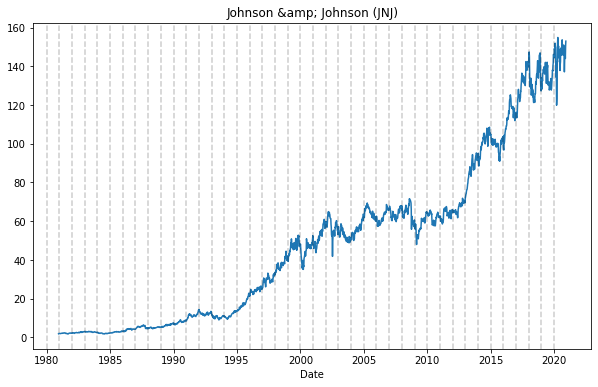

In [304]:
#Plotting closing price for companies as a time series
recordNum = 20

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(financialData[recordNum]['Close'])
plt.xlabel('Date')
plt.title(dow30info['Company'][recordNum] + ' (' + dow30info['Symbol'][recordNum]+')')
for year in range(1980,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

This is not stationary as it grows over time

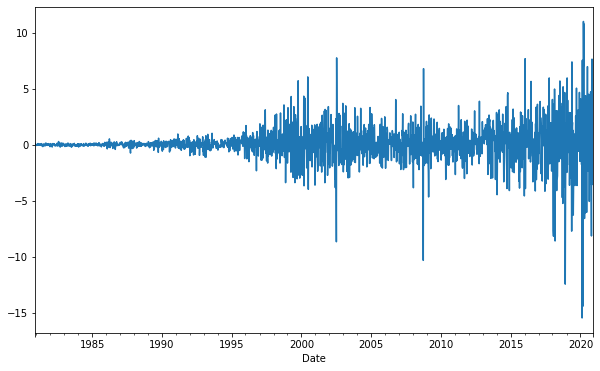

In [305]:
#We take the differences to make it stationary
import numpy as np
plt.figure(figsize=(10,6))
finDataDelta = financialData[recordNum][1:]['Close'].values - financialData[recordNum][:-1]['Close'].values
finDataDelta = np.concatenate([finDataDelta, [0]])

financialData[recordNum]['Delta'] = finDataDelta
financialData[recordNum]['Delta'].plot()
plt.show()

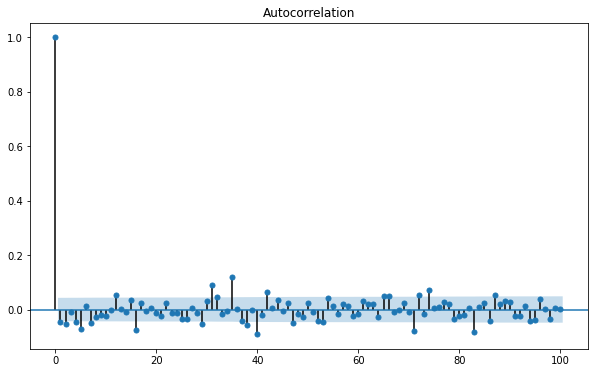

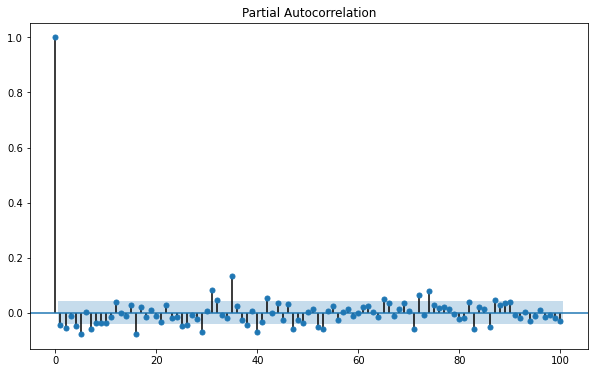

In [306]:
#Looking at Autocorrelation Function & Partial Autocorellation Fucntion
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rc("figure", figsize=(10,6))
plot_acf(financialData[recordNum]['Delta'],lags=100)
plt.show()

plt.rc("figure", figsize=(10,6))
plot_pacf(financialData[recordNum]['Delta'],lags=100)
plt.show()